2022-10-30

# 1. 상점 신용카드 매출 예측
## 1. 문제 정의

2016년 6월~ 2019년 2월까지의 신용카드 매출 데이터 -> 2019년 3월~ 2019년 5월의 상점별 3개월 총매출 예측

- 문제 해결 POINT
    - 예측해야하는 결과는 봄 시계열 값으로, 새학기, 황사 등 날씨 영향, 기념일(5 가정의달)등의 변수 有
    - 제출파일 평가하는 척도는 MAE : 실제값과 예측값의 차이에 절댓값을 취하고 평균을 계산한 손실함수
    

- 예측값에 영향을 미치는 변수 정의
    - 자영업자 : 평일ㆍ주말 , 시간대, 학기로 나눈 4분기, 공휴일, 개업ㆍ휴업ㆍ폐업
    - 카드사 : 포인트적립ㆍ사용, 할부, 현금, 환불ㆍ재결제, 통신장애
    - 고객 : usual cost(기본유지비), nonusual cost(예상치못한 소비), 고객 성향(저축orX), 월급날 기준 근처 결제 상황, 경제적 여유에 따른 결제 상황, 국가경제지표(경제성장률, 소비자 물가지수, 주식종합지수, 빅맥지수. 스타벅스 지수 등 )

### 1-1. 환경 설정

In [8]:
! pip install tqdm

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [18]:
# 시계열 데이터 분석 패키지 
! pip install pmdariam

  ERROR: Could not find a version that satisfies the requirement pmdariam (from versions: none)
ERROR: No matching distribution found for pmdariam
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [12]:
# statmodels : 검정 및 추정, 회귀분석 , 시계열 데이터 분석 등 통계분석 패키지
! pip install statsmodels==0.11.1

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


- 가상환경 커널 추가

In [13]:
! python -m ipykernel install --user --name store_amount_prediction --display-name "dacon_prediction"

Installed kernelspec store_amount_prediction in C:\Users\Seohyunjin\AppData\Roaming\jupyter\kernels\store_amount_prediction



### 1-2. 데이터 로드 및 확인

In [1]:
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")

train = pd.read_csv('data/funda_train.csv')
submission = pd.read_csv('data/submission.csv')

In [2]:
train.shape

(6556613, 9)

In [3]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


In [5]:
train[:5]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [6]:
train[train['amount']<0] 
# 매출액에 음수값은 환불을 의미 -> 이상치로 제거함

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
41,0,40,a,2016-06-10,17:26,2,NaN,기타 미용업,-8571.428571
347,0,285,a,2016-08-04,17:52,0,NaN,기타 미용업,-1857.142857
731,0,473,g,2016-10-17,10:32,0,NaN,기타 미용업,-2000.000000
831,0,230,b,2016-11-03,15:36,0,NaN,기타 미용업,-85.714286
944,0,138,a,2016-11-28,13:21,0,NaN,기타 미용업,-57.142857
...,...,...,...,...,...,...,...,...,...
6556242,2136,4663626,b,2019-02-01,21:19,0,제주 제주시,기타 주점업,-13428.571429
6556448,2136,4663760,d,2019-02-15,00:46,0,제주 제주시,기타 주점업,-6928.571429
6556485,2136,4663779,b,2019-02-18,02:45,0,제주 제주시,기타 주점업,-5571.428571
6556489,2136,4663780,d,2019-02-18,21:43,0,제주 제주시,기타 주점업,-8571.428571


## 2. 데이터 전처리
### 2-1. 노이즈 제거

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

train = pd.read_csv('data/funda_train.csv')
train.head() # region에 결측치 확인

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


#### (1) 단순 null 확인

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'store_id'),
  Text(1, 0, 'card_id'),
  Text(2, 0, 'card_company'),
  Text(3, 0, 'transacted_date'),
  Text(4, 0, 'transacted_time'),
  Text(5, 0, 'installment_term'),
  Text(6, 0, 'region'),
  Text(7, 0, 'type_of_business'),
  Text(8, 0, 'amount')])

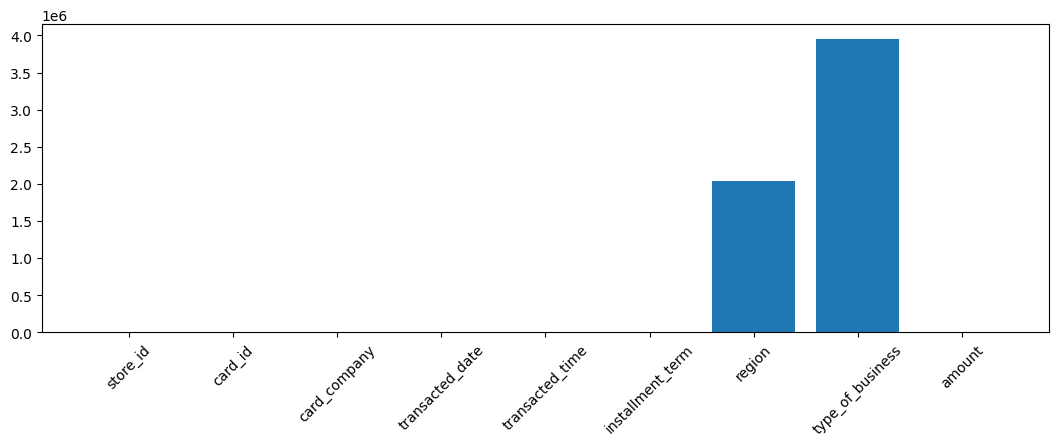

In [16]:

plt.figure(figsize=(13, 4))
plt.bar(train.columns, train.isnull().sum())
plt.xticks(rotation=45)
# 지역과 업종(type of business) 결측치 절반이상이 존재함. 범주형 속성이고, 대치방법 없어 -> 열 제거

In [3]:
train = train.drop(['region','type_of_business'],axis=1)
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


#### (2) 변수 특성에 맞는 이상치 탐색
- amount 매출액에 음수가 있을 경우는 '환불'을 의미하여, 추후 상점의 매출액을 예측할때 방해가 되는 noise임.

-> 환불 발생 시간 이전 거래중 음수값과 같은 절댓값(크기)의 양수값을 삭제 ( 결국 구매를 안한 것이기 때문 )
- 환불 발생일 및 발생 시간 이전 시점 확인 / 카드 아이디 확인 / 같은 절댓값을 가지는 거래 확인 -> index 기준 행제거

C:\Users\sk8er\anaconda3\envs\store_amount_prediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='amount'>

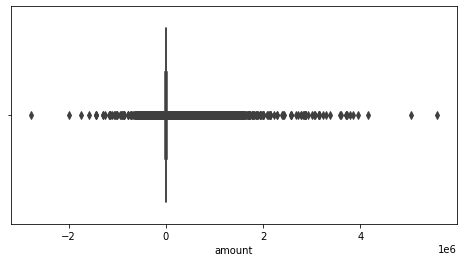

In [4]:
#2. 
plt.figure(figsize=(8, 4))
sns.boxplot(train['amount'])

In [5]:
train[train['amount']<0].head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
41,0,40,a,2016-06-10,17:26,2,-8571.428571
347,0,285,a,2016-08-04,17:52,0,-1857.142857
731,0,473,g,2016-10-17,10:32,0,-2000.000000
831,0,230,b,2016-11-03,15:36,0,-85.714286
944,0,138,a,2016-11-28,13:21,0,-57.142857


In [6]:
# 거래일와 거래시간을 합친 변수를 생성합니다.
train['datetime'] = pd.to_datetime(train.transacted_date + " " + 
                                train.transacted_time, format='%Y-%m-%d %H:%M:%S')
## 환불 거래를 제거하는 함수를 정의합니다.
def remove_refund(df):
    refund = df[df['amount']<0] # 매출액 음숫값 데이터를 추출합니다.
    non_refund = df[df['amount']>0] # 매출액 양숫값 데이터를 추출합니다.
    removed_data = pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()):
        # 매출액이 양숫값인 데이터를 상점별로 나눕니다.
        divided_data = non_refund[non_refund['store_id']==i] 
        # 매출액이 음숫값인 데이터를 상점별로 나눕니다.
        divided_data2 = refund[refund['store_id']==i] 
        
        for neg in divided_data2.to_records()[:]: # 환불 데이터를 차례대로 검사합니다.
            refund_store = neg['store_id']
            refund_id = neg['card_id'] # 환불 카드 아이디를 추출합니다.
            refund_datetime = neg['datetime'] # 환불 시간을 추출합니다.
            refund_amount = abs(neg['amount']) # 매출 음숫값의 절댓값을 구합니다.
                
            ## 환불 시간 이전의 데이터 중 카드 이이디와 환불액이 같은 후보 리스트를 뽑습니다.
            refund_pay_list = divided_data[divided_data['datetime']<=refund_datetime]
            refund_pay_list = refund_pay_list[refund_pay_list['card_id']==refund_id]
            refund_pay_list = refund_pay_list[refund_pay_list['amount']==refund_amount]
                     
            # 후보 리스트가 있으면 카드 아이디, 환불액이 같으면서 가장 최근시간을 제거합니다.
            if(len(refund_pay_list)!=0):
                refund_datetime = max(refund_pay_list['datetime']) # 가장 최근 시간을 구합니다
                noise_list = divided_data[divided_data['datetime']==refund_datetime] # 가장 최근시간
                noise_list = noise_list[noise_list['card_id']==refund_id] # 환불 카드 아이디
                noise_list = noise_list[noise_list['amount']==refund_amount] ## 환불액
                divided_data = divided_data.drop(index=noise_list.index) # 인덱스를 통해 제거
                    
        ## 제거한 데이터를 데이터프레임에 추가합니다.
        removed_data = pd.concat([removed_data,divided_data],axis=0)
    
    return removed_data

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [08:15<00:00,  3.97it/s]
C:\Users\sk8er\anaconda3\envs\store_amount_prediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='amount'>

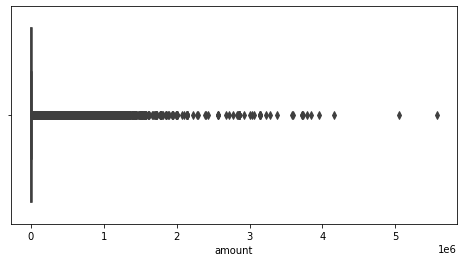

In [7]:
## 환불 거래 제거 함수를 통해 환불 거래를 제거
positive_data = remove_refund(train)
plt.figure(figsize=(8, 4))
sns.boxplot(positive_data['amount'])

### 2-2. 다운 샘플링
다운 샘플링 Downsampling : 시계열 데이터에서 시간간격을 넓게 재조정하여 데이터 샘플 수를 줄이는 것( 타임스탬프의 빈도를 줄임)

업 샘플링 Upsampling : (타임스탬프의 빈도를 늘림)

- 다운샘플링과 업샘플링은 index가 datetime 형식이여야 지원 가능 
- ★이때 , 목적 = 3개월간의 매출을 예측하는 것. BUT, 시간간격을 좁게해 시계열 모델을 만들면 예측해야하는 구간의 불확실성이 증가함 -> 다운샘플링을 통해 샘플의 수를 줄여 예측구간을 작게 해야함 


#### 다운 샘플링

원본 시계열보다 타임스탬프가 더 낮은 빈도로 발생하게끔 데이터의 부분집합을 생성
1) 원본데이터의 시간단위가 실용적이지 않은 경우 ( 너무 자주 측정하는 경우, 즉, 저장 공간 및 처리에 대한 부담만큼 새로운 정보가 아님)
2) 계절 주기의 특정 부분에 집중하는 경우 ( 1월만 보고싶을때만 매년 1월만 추출해서 확인)
3) 더 낮은 빈도의 데이터에 맞추는 경우 


#### 업 샘플링 
데이터가 실제보다 더 자주 수집된 것처럼 데이터를 표현
1) 시계열이 불규칙적인 상황 ( 불규칙한 시계열을 규칙적으로 변환할때)
2) 입력이 서로 다른 빈도로 샘플링된 상황 ( 서로 다른 빈도 데이터를 같은 시간대로 정렬하기 위해, 사전 관찰에 유의 필요)







In [8]:
# 5개의 행을 출력합니다.
positive_data.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00


In [9]:
## 월 단위 다운 샘플링 함수를 정의
def month_resampling(df):
    new_data = pd.DataFrame() 
    # 년도와 월을 합친 변수를 생성합니다.
    df['year_month'] = df['transacted_date'].str.slice(stop=7)
    # 데이터의 전체 기간을 추출합니다.
    year_month = df['year_month'].drop_duplicates()
    # 상점 아이디별로 월 단위 매출액 총합을 구합니다.
    downsampling_data = df.groupby(['store_id', 'year_month']).amount.sum()
    downsampling_data = pd.DataFrame(downsampling_data)
    downsampling_data = downsampling_data.reset_index(drop=False,inplace=False)
    
    for i in tqdm(df.store_id.unique()):
        # 상점별로 데이터를 처리합니다.
        store = downsampling_data[downsampling_data['store_id']==i]
        # 각 상점의 처음 매출이 발생한 월을 구합니다.
        start_time = min(store['year_month'])
        # 모든 상점을 전체 기간 데이터로 만듭니다.
        store = store.merge(year_month,how='outer')
        # 데이터를 시간순으로 정렬합니다.
        store = store.sort_values(by=['year_month'], axis=0, ascending=True) 
        store['amount'] = store['amount'].fillna(2)   # 매출이 발생하지 않는 월은 2로 채웁니다.
        store['store_id'] = store['store_id'].fillna(i)  # 상점 아이디 결측치를 채웁니다.
        store = store[store['year_month']>=start_time]  # 처음 매출이 발생한 월 이후만 뽑습니다.
        
        new_data = pd.concat([new_data,store],axis=0)
        
    return new_data


In [10]:
# 환불 제거 데이터를 월 단위로 다운 샘플링
resampling_data = month_resampling(positive_data)
resampling_data['store_id'] = resampling_data['store_id'].astype(int)
resampling_data


100%|█████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:08<00:00, 236.62it/s]


,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.697143e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.354286e+05
...,...,...,...
17,2136,2018-10,2.012214e+06
18,2136,2018-11,2.127643e+06
19,2136,2018-12,2.427429e+06
20,2136,2019-01,1.867786e+06



- 다운 샘플링 이유

거래 시간을 준으로 분단위로 기록된 결제 이력 데이터: positive_data
이를 그대로 사용하면, 예측구간이 분단위로 너무 많아져 불확실성이 커짐-> 정확도 떨어짐
따라서, 시간간격을 재조정해 예측구간을 최소화. 분단위 데이터 -> 월단위로 재조정 : 다운 샘플링 진행

- 매출 미발생월 대치 값 설정 

다운 샘플링 진행시 매출 미발생월은 2로 대치. 
0으로 대치하지 않은 이유 :  시계열 데이터의 진동폭을 안정화 하기 위해 로그 정규화를 진행하기 때문.
(1이하의 값을 로그정규화 진행시 음수 또는 무한대가 나오기 때문)

- 이번 과제는 월단위로 다운 샘플링을 진행 했을때 예측성능이 가장 우수했음.

### 2-3. 날짜 지정 범위 생성과 시리즈 객체 변환
데이터 프레임을 시리즈 객체로 변환

시계열 데이터의 정상성을 확인하기 위한 단위근 검정과 시계열 모델 구축 과정에서 시리즈 객체를 사용

- 시계열 분석을 위해 date_range 함수를 이용해 인덱스를 시간변수로 정의

In [11]:
## 데이터 타입을 출력
print(type(resampling_data))

<class 'pandas.core.frame.DataFrame'>


In [12]:
# 데이터프레임을 Series로 변환하는 함수
def time_series(df, i):
    # 상점별로 데이터를 뽑습니다.
    store = df[df['store_id']==i]
    ## 날짜 지정 범위는 영업 시작 월부터 2019년 3월 전까지 영업 마감일 기준
    index = pd.date_range(min(store['year_month']),'2019-03',freq='BM') 
    ## 시리즈 객체로 변환
    ts = pd.Series(store['amount'].values,index=index)
    return ts

In [13]:
# 상점 아이디가 0번인 데이터를 시리즈 객체로 변환
store_0 = time_series(resampling_data, 0)
store_0

2016-06-30    7.470000e+05
2016-07-29    1.005000e+06
2016-08-31    8.697143e+05
2016-09-30    8.978571e+05
2016-10-31    8.354286e+05
2016-11-30    6.970000e+05
2016-12-30    7.618571e+05
2017-01-31    5.856429e+05
2017-02-28    7.940000e+05
2017-03-31    7.202571e+05
2017-04-28    6.852857e+05
2017-05-31    7.444286e+05
2017-06-30    6.820000e+05
2017-07-31    7.282857e+05
2017-08-31    7.490000e+05
2017-09-29    8.408571e+05
2017-10-31    6.005714e+05
2017-11-30    6.308571e+05
2017-12-29    8.127143e+05
2018-01-31    6.431429e+05
2018-02-28    6.852857e+05
2018-03-30    8.484286e+05
2018-04-30    6.361429e+05
2018-05-31    6.864286e+05
2018-06-29    7.072857e+05
2018-07-31    7.587143e+05
2018-08-31    6.798571e+05
2018-09-28    6.518571e+05
2018-10-31    7.390000e+05
2018-11-30    6.760000e+05
2018-12-31    8.745714e+05
2019-01-31    6.828571e+05
2019-02-28    5.152857e+05
Freq: BM, dtype: float64

In [14]:
## 데이터 타입을 출력
store_1 = time_series(resampling_data, 1)
print(type(store_1))

<class 'pandas.core.series.Series'>


<AxesSubplot:>

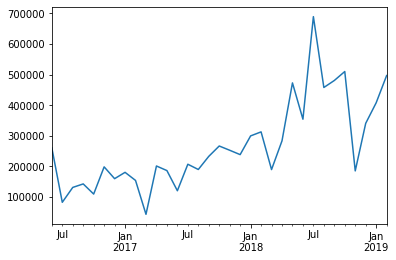

In [15]:
# 상점 아이디가 2번인 데이터를 시리즈 객체로 변환
store_2 = time_series(resampling_data, 2)
store_2.plot()

매출의 자잘한 변동 폭 기록 -> 로그 정규화 진행시 변동이 안정화 되어 더 큰 트렌드를 파악 할 수 있음.

## 3. 탐색적 데이터 분석

시계열 데이터의 평균과 분산이 안정적인지 확인하기 위하여 ADF-TEST를 진행

### 3-1. 상점별 매출 특성
#### (1) 계절성이 있는 상점

In [16]:
# 상점 아이디가 257번인 데이터를 시리즈 객체로 데이터 출력
store_257 = time_series(resampling_data, 257)
store_257

2016-06-30    4.891857e+05
2016-07-29    1.595280e+06
2016-08-31    1.518714e+06
2016-09-30    3.369143e+05
2016-10-31    4.245714e+05
2016-11-30    2.000000e+00
2016-12-30    2.000000e+00
2017-01-31    2.000000e+00
2017-02-28    2.000000e+00
2017-03-31    2.000000e+00
2017-04-28    3.928571e+04
2017-05-31    1.557286e+05
2017-06-30    5.481143e+05
2017-07-31    7.359286e+05
2017-08-31    7.909700e+05
2017-09-29    6.191429e+04
2017-10-31    1.027143e+06
2017-11-30    2.000000e+00
2017-12-29    2.000000e+00
2018-01-31    2.000000e+00
2018-02-28    2.000000e+00
2018-03-30    2.000000e+00
2018-04-30    2.000000e+00
2018-05-31    2.493857e+05
2018-06-29    4.822286e+05
2018-07-31    8.999714e+05
2018-08-31    1.645877e+06
2018-09-28    2.767857e+05
2018-10-31    2.000000e+00
2018-11-30    2.000000e+00
2018-12-31    2.000000e+00
2019-01-31    2.000000e+00
2019-02-28    2.000000e+00
Freq: BM, dtype: float64

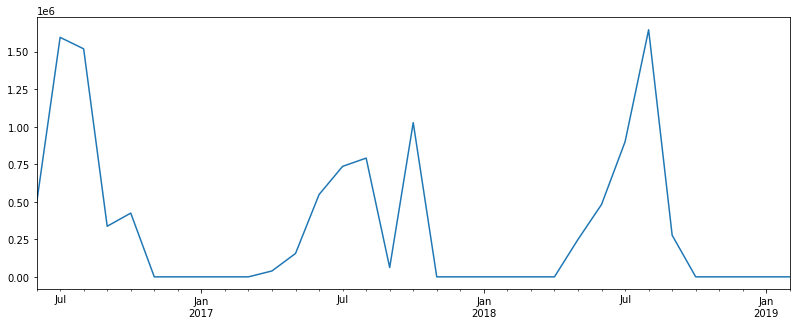

In [17]:
# 시계열 그래프 그리기
store_plot_257 = store_257.plot()
fig = store_plot_257.get_figure()
fig.set_size_inches(13.5,5)

In [18]:
# 상점 아이디가 2096번인 데이터를 시리즈 객체로 데이터 출력
store_2096 = time_series(resampling_data, 2096)
store_2096

2016-07-29    5.075429e+04
2016-08-31    9.219543e+05
2016-09-30    4.720786e+05
2016-10-31    5.145714e+05
2016-11-30    1.494286e+05
2016-12-30    1.071686e+06
2017-01-31    1.602857e+06
2017-02-28    1.332143e+06
2017-03-31    2.432143e+05
2017-04-28    3.903143e+06
2017-05-31    1.729500e+06
2017-06-30    4.280214e+06
2017-07-31    1.775714e+06
2017-08-31    7.428571e+05
2017-09-29    1.415714e+06
2017-10-31    1.180714e+06
2017-11-30    4.640000e+05
2017-12-29    1.389729e+06
2018-01-31    2.000000e+00
2018-02-28    8.285714e+05
2018-03-30    7.857143e+05
2018-04-30    6.670429e+06
2018-05-31    1.837286e+05
2018-06-29    3.285714e+06
2018-07-31    9.502857e+05
2018-08-31    3.675200e+06
2018-09-28    1.793886e+06
2018-10-31    4.717743e+06
2018-11-30    7.593600e+06
2018-12-31    1.428571e+06
2019-01-31    4.285714e+05
2019-02-28    1.428571e+06
Freq: BM, dtype: float64

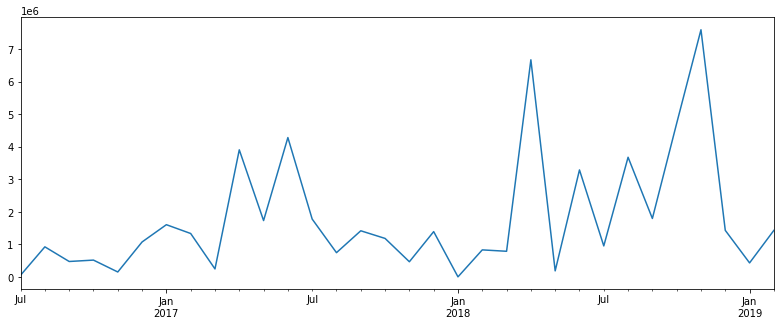

In [19]:
# 상점 아이디가 2096번인 상점의 시계열 그래프
store_plot_2096 = store_2096.plot()
fig = store_plot_2096.get_figure()
fig.set_size_inches(13.5,5)

#### (2) 추세가 있는 상점

꾸준히 증가 또는 꾸준히 감소하는 추세
( SNS 마케팅, 광고 등이 상승의 이유가 될 수 있으며, 위생단속 적발, 취급제품의 문제점 부각, 상점이미지 추락이 하락의 이유가 될수 있음 )

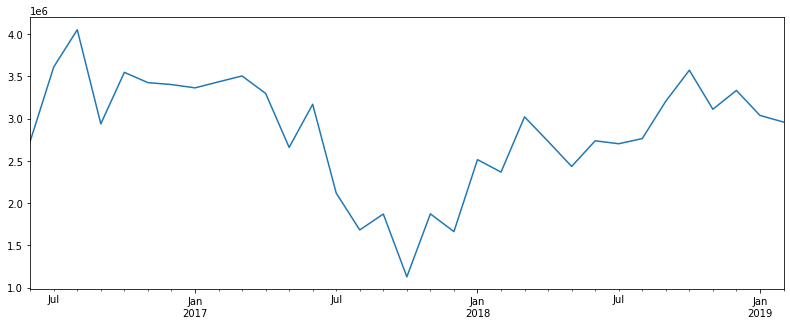

In [20]:
# 상점 아이디가 335번인 상점의 시계열 그래프
store_335 = time_series(resampling_data, 335)
store_plot_335 = store_335.plot()
fig = store_plot_335.get_figure()
fig.set_size_inches(13.5,5)

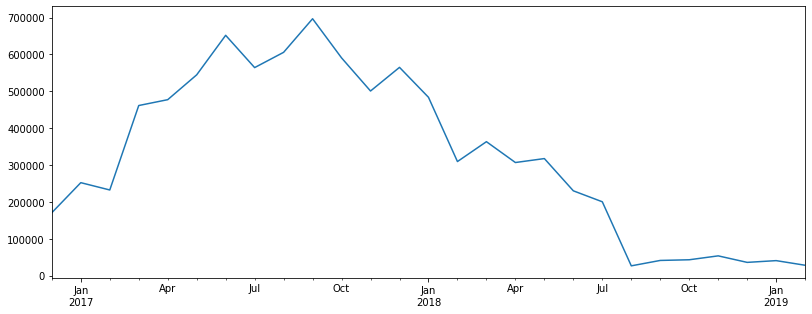

In [21]:
# 상점 아이디가 510번인 상점의 시계열 그래프
store_510 = time_series(resampling_data, 510)
store_plot_510 = store_510.plot()
fig = store_plot_510.get_figure()
fig.set_size_inches(13.5,5)

#### (3) 휴업 중인 상점

In [22]:
# 상점 아이디가 111번인 데이터를 시리즈 객체로 데이터 출력
store_111 = time_series(resampling_data, 111)
store_111

2016-06-30    812428.571429
2016-07-29    391142.857143
2016-08-31     13071.428571
2016-09-30    495714.285714
2016-10-31    182714.285714
2016-11-30    178571.428571
2016-12-30     43005.714286
2017-01-31         2.000000
2017-02-28      5428.571429
2017-03-31     24857.142857
2017-04-28    108000.000000
2017-05-31    459142.857143
2017-06-30    137571.428571
2017-07-31    216285.714286
2017-08-31     77000.000000
2017-09-29     78005.714286
2017-10-31         2.000000
2017-11-30         2.000000
2017-12-29         2.000000
2018-01-31      1428.571429
2018-02-28    309785.714286
2018-03-30    259071.428571
2018-04-30    225858.571429
2018-05-31    105571.428571
2018-06-29         2.000000
2018-07-31    123285.714286
2018-08-31         2.000000
2018-09-28     83000.000000
2018-10-31         2.000000
2018-11-30         2.000000
2018-12-31         2.000000
2019-01-31         2.000000
2019-02-28         2.000000
Freq: BM, dtype: float64

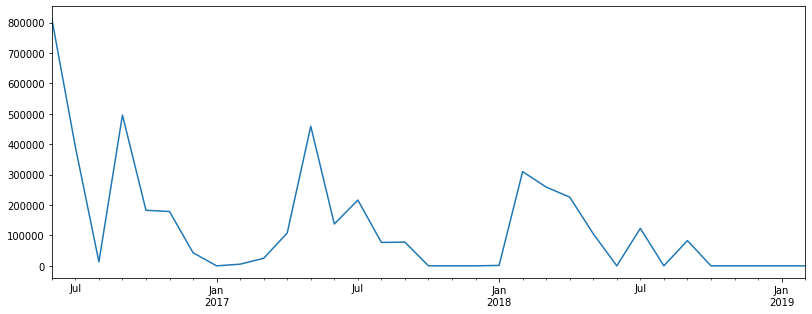

In [23]:
# 상점 아이디가 111번인 상점의 시계열 그래프
store_plot_111 = store_111.plot()
fig = store_plot_111.get_figure()
fig.set_size_inches(13.5,5)

In [24]:
# 상점 아이디가 279번인 데이터를 시리즈 객체로 데이터 출력
store_279 = time_series(resampling_data, 279)
store_279

2016-06-30    4.488571e+05
2016-07-29    1.156286e+06
2016-08-31    1.372857e+06
2016-09-30    3.150000e+05
2016-10-31    8.748571e+05
2016-11-30    3.128571e+05
2016-12-30    5.828571e+05
2017-01-31    3.214286e+04
2017-02-28    2.000000e+00
2017-03-31    4.955714e+05
2017-04-28    5.940000e+05
2017-05-31    1.041143e+06
2017-06-30    8.354286e+05
2017-07-31    6.171429e+05
2017-08-31    4.284286e+05
2017-09-29    1.581258e+06
2017-10-31    3.294286e+05
2017-11-30    2.241429e+05
2017-12-29    2.785714e+05
2018-01-31    4.018571e+05
2018-02-28    1.282857e+05
2018-03-30    2.000000e+00
2018-04-30    2.000000e+00
2018-05-31    2.000000e+00
2018-06-29    2.000000e+00
2018-07-31    2.000000e+00
2018-08-31    2.000000e+00
2018-09-28    2.000000e+00
2018-10-31    2.000000e+00
2018-11-30    2.101429e+05
2018-12-31    2.191571e+05
2019-01-31    1.779286e+05
2019-02-28    5.157143e+04
Freq: BM, dtype: float64

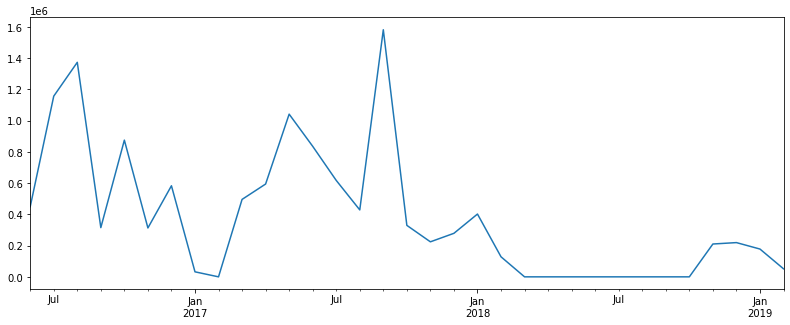

In [25]:
# 상점 아이디가 279번인 상점의 시계열 그래프
store_plot_279 = store_279.plot()
fig = store_plot_279.get_figure()
fig.set_size_inches(13.5,5)

### 3-2. 시계열 데이터의 정상성

시계열 데이터 內 정상성 = 추세나 계절성이 없는 시계열 데이터, 즉 시간의 변동에 따라 평균과 분산이 일정함을 의미

따라서, 정상성 판단을 위해 ADF-TEST 진행

(https://geniewishescometrue.tistory.com/entry/Time-Series-Stationarity-%EC%8B%9C%EA%B3%84%EC%97%B4%EB%B6%84%EC%84%9D-%EC%A0%95%EC%83%81%EC%84%B1-ADF-Test-%EC%B0%A8%EB%B6%84)
(https://otexts.com/fppkr/stationarity.html)



#### ADF-TEST
시계열 데이터가 정상성을 가지는지 판단할때 사용하며, 회귀 분석의 결과로 나온 계수를 검정통계량으로 사용.
 
시계열데 단위근이 존재하는지 여부를 검정함으로써 정상시계열 여부를 확인 ( 단위근 존재시, 비정상 시계열) 


from statsmodels.tsa.stattools import adfuller (https://rfriend.tistory.com/694)

만약, 정상성을 가지지 않는 다면 차분을 통해 평균을 일정하게 만들어 주어야 함. 
 * 차분 = 비정상 시계열 데이터를 평균이 일정한 정상 시계열로 바꾸는 기법 

#### 차분
차분은 t 시점의 데이터가 t-1시점의 데이터에 비해 얼마나 증감했는지 알수 있음

n차 차분 : t시점 y의 n차 미분값 = t시점 y - (t-1)시점 y -....- (t-n)시점 y

- 1차 차분 공식

    rides["lag_1"] = rides["rides"].shift(periods=1)  # shift함수를 통해 t기의 데이터를 t-1로 미룸

    rides['직접 구한 diff_1'] = rides['rides'] - rides['lag_1'] 

    rides['함수로 구한 diff_1'] = rides['rides'].diff(1) 

- 2차 차분 공식 

    rides['diff_1 + lag_1'] = rides['diff_1'].shift(1)

    rides['직접 구한 diff_2'] = rides['diff_1'] - rides['diff_1 + lag_1']
    
    rides['함수로 구한 diff_2'] = rides['rides'].diff().diff()


**** 단, ADF -TEST는 추세가 있는 비정상 시계열에 대해서는 정상 시계열이 아님을 잘 검정하지만, 분산이 변하거나 계절성이 있는 시계열에 대해서는 정상성 여부를 제대로 검정해내지 못함

반면에 ,KPSS test 는 잘 검정함.
from statsmodels.tsa.stattools import kpss


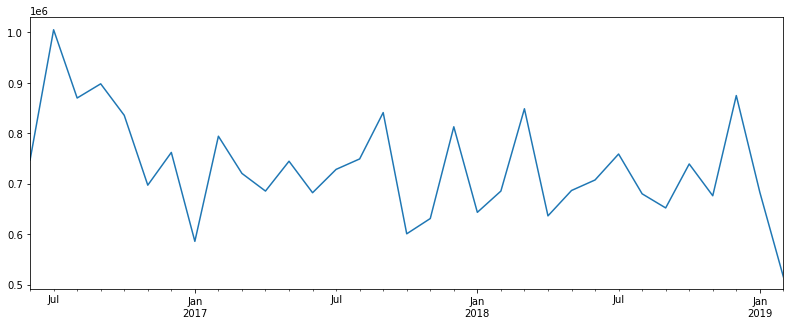

In [26]:
# 상점 아이디가 0번인 상점의 시계열 그래프
store_0 = time_series(resampling_data, 0)
store_plot_0 = store_0.plot()
fig = store_plot_0.get_figure()
fig.set_size_inches(13.5,5)

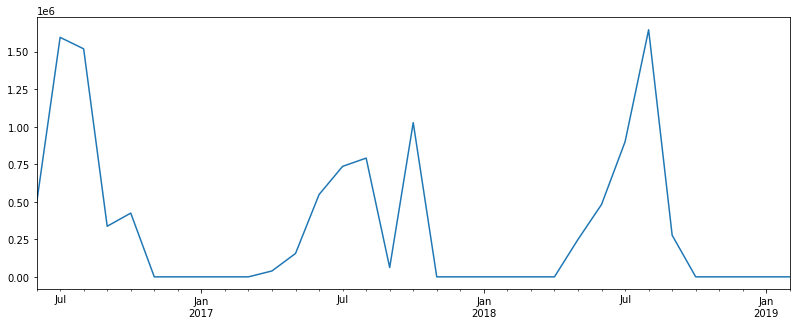

In [27]:
# 상점 아이디가 257번인 상점의 시계열 그래프
store_257 = time_series(resampling_data, 257)
store_plot_257 = store_257.plot()
fig = store_plot_257.get_figure()
fig.set_size_inches(13.5,5)

In [28]:
# pmdarima 패키지에 있는 ADFTest 클래스를 임포트
from pmdarima.arima import ADFTest

# 상점 아이디가 0번인 데이터를 시리즈 객체로 변환
store_0 = time_series(resampling_data, 0)
# ADF-Test 시행
p_val, should_diff = ADFTest().should_diff(store_0)
print('p_val : %f , should_diff : %s' %(p_val, should_diff))

p_val : nan , should_diff : False


In [29]:
# 상점 아이디가 257번인 데이터를 시리즈 객체로 변환
store_257 = time_series(resampling_data, 257)
# ADF-Test 시행
p_val, should_diff = ADFTest().should_diff(store_257)
print('p_val : %f , should_diff : %s' %(p_val, should_diff))

p_val : 0.093614 , should_diff : True


257번 매출 시계열은 정상 P-value가 0.05보다 큼. 정상 시계열이 아니며, 차분이 필요함.

이렇게 일일히 확인 할 수 는 없음. p-value 값을 리스트에 저장해 상자그림으로 p-value의 분포를 확인

매출이 수개월간 발생하지 않는 상점을 예외처리 진행

100%|█████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:04<00:00, 450.89it/s]
C:\Users\sk8er\anaconda3\envs\store_amount_prediction\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

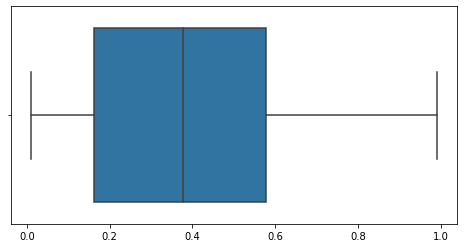

In [30]:
## ARIMA 모델의 차분 여부를 결정하기 위한 단위근 검정
def adf_test(y):
    return ADFTest().should_diff(y)[0]

adf_p = []
count = 0
skipped = []

for i in tqdm(resampling_data['store_id'].unique()):
    ts = time_series(resampling_data,i)
    try:
        p_val = adf_test(ts)
        if p_val < 0.05:
            count += 1
        adf_p.append(p_val)
    except:
        skipped.append(i)

plt.figure(figsize=(8, 4))
sns.boxplot(adf_p)

In [31]:
# p-value가 0.05보다 작은 상점의 개수
print(count)

259


In [32]:
# ADF-Test 오류 상점 개수
if skipped:
    print(f"WarningCount: {len(skipped)}, store_id_list:{skipped}")

WarningCount: 1, store_id_list:[795]


비정상 시계열 값은 차분해 정상시계열로 변환

## 4 모델 구축과 검증
### 4-1. 파이썬에서 R 시계열 패키지 forecast를 통한 모델링

In [33]:
from rpy2.robjects.packages import importr # rpy2 내의 패키지를 불러올 importr 클래스

utils = importr('utils') # utils 패키지를 임포트
utils.install_packages('forecast') # r의 forecast 패키지 설치.
utils.install_packages('forecastHybrid') # r의 forecastHybrid 패키지 설치

rpy2.rinterface.NULL

In [34]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

auto_arima = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

store_0 = resampling_data[resampling_data['store_id']==0]
start_year = int(min(store_0['year_month'])[:4]) # 영업 시작 년도
start_month = int(min(store_0['year_month'])[5:]) # 영업 시작 월
    
# R의 ts 함수로 r의 time series 자료형으로 변환
train = ts(store_0['amount'], start=c(start_year, start_month), frequency=12) 

#ensemble model
forecast = auto_arima(train)
np.sum(pandas2ri.ri2py(forecast).values) # 3개월 매출을 합산

C:\Users\sk8er\anaconda3\envs\store_amount_prediction\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


2007226.9722140946

### 4-2. 시계열 모델 선택과 검증
#### (1) 자기회귀누적이동평균 모델


- AR모델 : 자기회귀 모델
미래 예측에 자기 과거를 사용하여, 자신의 이전 관측값이 자신의 이후 관측값에 영향을 주는 모델 

- MA모델 : 이동평균 과정
현재 시계열 데이터가 과거 잔차들의 가중평균으로 구성된다는 모델
잔차항은 백색잡음을 의히하며, 현재 데이터는 과거 백색잡음의 평균값으로 설명된다.

- ARiMA : 자기회귀누적이동평균 ( I : 차분을 구함)
시계열 데이터가 정상성인 경우에 주로 적용하며, 초기 차분단계를 한번 이상 적용해 비 정상성을 제거할 수 있음.

In [35]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

auto_arima = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)# str 형식으로 정의된 auto_arima
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4]) ## 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) ## 영업 시작 월
    # R의 ts 함수로 time series 데이터로 변환
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 
    # 자동회귀누적이동평균 model
    forecast = auto_arima(train)
    # 3개월 매출을 합산, final_pred에 추가
    final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [01:24<00:00, 23.39it/s]


In [36]:
submission = pd.read_csv('./submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission.csv', index=False)
submission

,store_id,amount
0,0,2.007227e+06
1,1,2.886210e+05
2,2,1.276695e+06
3,4,2.697649e+06
4,5,8.291391e+05
...,...,...
1962,2132,2.190377e+06
1963,2133,7.414846e+05
1964,2134,9.818183e+04
1965,2135,1.755864e+06


#### (2) 지수평활법

- 단순지수평활법

: 가장 최근 관측값을 가장 중요하게 생각하여 이전 모든 관측값은 미래를 예측할때 아무런 정보도 주지 않는다고 가정.
따라서, 미래를 예측할 때, 가장 최근에 관측된 값에 가중치를 더 많이 줌. 

-> 추세나 계절성이 없을 때 주로 사용

단순지수평활법에서 가중치에 해당하는 계수는 잔차 제곱의 합을 최소화해 추정.

- 홀트선형추세 기법 
: 추세가 있는 데이터를 예측할 수 있게 단순지수평활법을 확장한 방법


★ 여러 지수평활모델 중 해당 시계열 데이터에 맞는 모델을 찾아야함 

=> R의 ets() 함수를 이용하면, 시계열 데이터에 대해 AIC 값을 최소로 해주는 지수평활 모델을 추정 할 수 있음

AIC는 주어진 데이터 셋에서 통계모델의 상대적 품질을 나타내는 값으로, 낮을수록 좋은 모델

(모델의 적합도가 높고 파라미터의 개수가 작은 모델을 찾을때 도움 됨)


In [37]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)# str 형식으로 정의된 ets
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    # R의 ts 함수로 time series 데이터로 변환
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 
    # 지수평활법l
    forecast = ets(train)
    # 3개월 매출을 합산, final_pred에 추가
    final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [09:07<00:00,  3.59it/s]


In [38]:
submission = pd.read_csv('./submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission.csv', index=False)
submission

,store_id,amount
0,0,2.060501e+06
1,1,2.878790e+05
2,2,1.260318e+06
3,4,2.668637e+06
4,5,7.091162e+05
...,...,...
1962,2132,2.190512e+06
1963,2133,3.488475e+05
1964,2134,4.249576e+05
1965,2135,1.622992e+06


#### (3) STL 분해를 적용한 지수평활법

STL : 시계열 분해 기법으로, 시계열 데이터가 가진 시간 주기를 알고 있는 경우 시계열 데이터의 계절성과 추세, 나머지 성분으로 분해해 분석하는 기법

C:\Users\sk8er\anaconda3\envs\store_amount_prediction\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


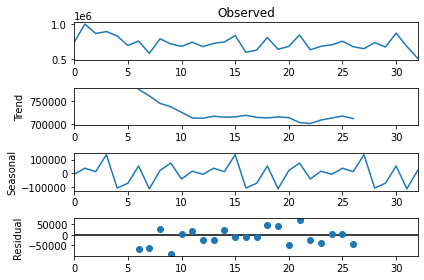

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

store_0 = time_series(resampling_data, 0)
# STL 분해
stl = seasonal_decompose(store_0.values, freq=12)
stl.plot()
plt.show()

In [40]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()
stlm = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = stlm(ts, s.window="periodic", method='ets') # STL 분해 후 지수평활법을 통한 예측 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r을 파이썬에서 사용 가능
stlm = robjects.r(stlm)# str 형식으로 정의된 stlm
ets = robjects.r(ets)# str 형식으로 정의된 ets
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    data_len = len(store)
    
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    # R의 ts 함수로 time series 데이터로 변환
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 
    # STL 분해를 적용한 지수평활 model
    if data_len > 24:
        forecast = stlm(train)
    # 지수평활 model
    else:
        forecast = ets(train)    # 3개월 매출을 합산, final_pred에 추가
    final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))


  0%|                                                                                         | 0/1967 [00:00<?, ?it/s]C:\Users\sk8er\anaconda3\envs\store_amount_prediction\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [01:17<00:00, 25.27it/s]


In [41]:
submission = pd.read_csv('./submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission.csv', index=False)
submission

,store_id,amount
0,0,2.094277e+06
1,1,2.774723e+05
2,2,1.164701e+06
3,4,2.750955e+06
4,5,9.395993e+05
...,...,...
1962,2132,2.138210e+06
1963,2133,8.242583e+05
1964,2134,4.061268e+05
1965,2135,1.578473e+06


## 5. 성능 향상을 위한 방법
### 5.1 상점 매출액의 로그 정규화

더 튼 트렌드를 파악하기 위해 진행
-> 결과를 보면 실제값(TEST)와의 차이가 더 작은 로그정규화 취한 것이 더 성능이 좋음


BUT, 정규화 한다고 무조건 성능이 좋아지는 것은 아님.

실험결과, 
매출액 변동계수가 높은 상점을 로그정규화 진행시 예측 성능이 저하됨. -> 변동계수 0.3 미만인 상점만 로그정규화 진행해 예측


In [42]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
import numpy as np

# pandas2ri를 활성화 
pandas2ri.activate()

auto_arima = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""

# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log')# 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

# 0번 상점 추출
store_0 = resampling_data[resampling_data['store_id']==0]
start_year = int(min(store_0['year_month'])[:4]) # 영업 시작 년도
start_month = int(min(store_0['year_month'])[5:]) # 영업 시작 월

# train, test 분리
train = store_0[store_0.index <= len(store_0)-4]
test = store_0[store_0.index > len(store_0)-4]

# R의 ts 함수로 r의 time series 자료형으로 변환
train_log = ts(log(train['amount']), start=c(start_year, start_month), frequency=12) # log 정규화 
train = ts(train['amount'], start=c(start_year, start_month), frequency=12) # log 정규화를 하지 않음

# model arima
forecast_log = auto_arima(train_log)
forecast = auto_arima(train)

# pred
pred_log = np.sum(pandas2ri.ri2py(exp(forecast_log)).values) #로그 역변환 후 3개월 합산
pred = np.sum(pandas2ri.ri2py(forecast).values) #3개월 매출을 합산

# test(2018-12~2019-02)
test = np.sum(test['amount'])

# mae
print('log-regularization mae: ', abs(test-pred_log))
print('mae:', abs(test-pred))

log-regularization mae:  2401.9664819482714
mae: 5884.674066892825


In [43]:
# 매출 변동 계수를 구하는 함수
def coefficient_variation(df, i):
    cv_data = df.groupby(['store_id']).amount.std()/df.groupby(['store_id']).amount.mean()
    cv = cv_data[i]
    return cv

In [44]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
import numpy as np

# pandas2ri를 활성화 
pandas2ri.activate()

ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""

# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)
ts = robjects.r('ts') # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    
    cv = coefficient_variation(resampling_data, i)
    # 매출액 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        train_log = ts(log(store['amount']), start=c(start_year,start_month), frequency=12) 
        # ets model
        forecast_log = ets(train_log)
        final_pred.append(np.sum(pandas2ri.ri2py(exp(forecast_log)).values))
    # 매출액 변동 계수가 0.3 이상인 경우
    else:
        train = ts(store['amount'], start=c(start_year,start_month), frequency=12)
        # 지수평활법
        forecast = ets(train)
        final_pred.append(np.sum(pandas2ri.ri2py(forecast).values)) 

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [10:34<00:00,  3.10it/s]


In [45]:
submission = pd.read_csv('./submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission.csv', index=False)
submission

,store_id,amount
0,0,1.963401e+06
1,1,2.483335e+05
2,2,1.260318e+06
3,4,2.660373e+06
4,5,7.091162e+05
...,...,...
1962,2132,2.122653e+06
1963,2133,3.488475e+05
1964,2134,4.249576e+05
1965,2135,1.603989e+06


### 5.2.	파이썬에서 R 시계열 패키지 forecastHybrid를 통한 앙상블

In [46]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
import numpy as np

# pandas2ri를 활성화 
pandas2ri.activate()

hybridModel = """
    function(ts){
        library(forecast)
        library(forecastHybrid)
        d_params=ndiffs(ts)
        hb_mdl<-hybridModel(ts, models="aes", # auto_arima, ets, stlm
                        a.arg=list(max.p=2, d=d_params), # auto_arima parameter
                        weight="equal") # 가중치를 동일하게 줌(평균)
        forecasted_data<-forecast(hb_mdl, h=3) # 이후 3개월(h=3)을 예측
        outdf<-data.frame(forecasted_data$mean)
        colnames(outdf)<-c('amount')
        outdf
    }
""" 

# r() 함수로 r 자료형을 파이썬에서 사용 가능
hybridModel = robjects.r(hybridModel)
ts = robjects.r('ts') # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    
    cv = coefficient_variation(resampling_data, i)
    # 매출액 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        train_log = ts(log(store['amount']), start=c(start_year,start_month), frequency=12) 
        # 앙상블 예측
        forecast_log = hybridModel(train_log)
        final_pred.append(np.sum(pandas2ri.ri2py(exp(forecast_log)).values)) 
    # 매출액 변동 계수가 0.3 이상인 경우
    else:
        train = ts(store['amount'], start=c(start_year,start_month), frequency=12)
        # 앙상블 예측
        forecast = hybridModel(train)
        final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))


100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [12:32<00:00,  2.61it/s]


In [47]:
submission = pd.read_csv('./submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission.csv', index=False)
submission

,store_id,amount
0,0,1.996290e+06
1,1,2.653045e+05
2,2,1.240681e+06
3,4,2.695279e+06
4,5,8.240620e+05
...,...,...
1962,2132,2.115933e+06
1963,2133,6.311052e+05
1964,2134,3.021292e+05
1965,2135,1.626442e+06
